# EECE 571T Project - NLP with Emotion Dataset (Word Embedding w/ LSTM)

Focus: Word Embedding
<br>
Author: Tom Sung

Last updated:
* Date: March 15, 2022
* Time: 6:00pm

To Do [March 15]:
* Add Tensorboard
* Consider not using dropout at all...?

## References
(There are more references throughout the document, I just haven't consolidated them all here yet)

* Making our own word2vec model: https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
* https://medium.com/@adriensieg/text-similarities-da019229c894
* Text Classification tutorial: https://github.com/adsieg/Multi_Text_Classification
* From same author:
    * [**Feb.17**] This is used for the Word Embedding part: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 (Try following these instructions next)
    * [**Feb.17**] https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
* Different Pre-Processing Techniques with Bag of Words w/ TF-IDF, Word Embedding, and BERT: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

# Get data from GitHub repo

**Only run this once even after if notebook environment is cleared via** `%reset -f`. The code written here imports the Kaggle data set, which I have placed on my public GitHub repo.

In [1]:
!wget https://github.com/tkjsung/EECE571T_Dataset/archive/refs/heads/master.zip
!unzip /content/master.zip
# For local computer use:
# !unzip master.zip

--2022-03-16 00:52:03--  https://github.com/tkjsung/EECE571T_Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tkjsung/EECE571T_Dataset/zip/refs/heads/master [following]
--2022-03-16 00:52:03--  https://codeload.github.com/tkjsung/EECE571T_Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>               ] 798.87K  3.43MB/s    in 0.2s    

2022-03-16 00:52:03 (3.43 MB/s) - ‘master.zip’ saved [818042]

Archive:  /content/master.zip
f84fef58c648047c03c671498e0375bf224f000e
   creating: EECE571T_Dataset-master/
  inflating: 

# Import Data

In [2]:
# Import libraries for data import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
# Read CSV
# data_train = pd.read_csv('/content/EECE571T_Dataset-master/Project/train.txt',sep=';', header=None)
# data_test = pd.read_csv('/content/EECE571T_Dataset-master/Project/test.txt',sep=';', header=None)
# data_val = pd.read_csv('/content/EECE571T_Dataset-master/Project/val.txt',sep=';', header=None)

# Read CSV on local computer
data_train = pd.read_csv('EECE571T_Dataset-master/Project/train.txt',sep=';', header=None)
data_test = pd.read_csv('EECE571T_Dataset-master/Project/test.txt',sep=';', header=None)
data_val = pd.read_csv('EECE571T_Dataset-master/Project/val.txt',sep=';', header=None)

In [4]:
col_names = ["sentence","emotion"]
data_train.columns = col_names
data_test.columns = col_names
data_val.columns = col_names

In [5]:
# See the data head to make sure data is imported correctly.
data_train.head()
# data_test.head()
# data_val.head()

,sentence,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Encode the emotion labels with unique identifiers

In [6]:
from sklearn.preprocessing import LabelEncoder
# Encode the emotion labels with unique identifiers
data_train['emotion'].unique()
labelencoder = LabelEncoder()
data_train['emotion_enc'] = labelencoder.fit_transform(data_train['emotion'])
data_test['emotion_enc'] = labelencoder.fit_transform(data_test['emotion'])
data_val['emotion_enc'] = labelencoder.fit_transform(data_val['emotion'])
# For data_test and data_val, use the same labelencoder. Make sure it's the same by using the display code below.

Sort the encoded emotion labels for some classification reports later

In [7]:
emotion_label_list = data_train[['emotion','emotion_enc']].drop_duplicates(keep='first')
# data_test[['emotion','emotion_enc']].drop_duplicates(keep='first')
# data_val[['emotion','emotion_enc']].drop_duplicates(keep='first')
emotion_label_list = emotion_label_list.sort_values(by='emotion_enc')
emotion_label_list.iloc[0]

emotion        anger
emotion_enc        0
Name: 2, dtype: object

In [8]:
data_train.head()
data_test.head()
data_val.head()

,sentence,emotion,emotion_enc
0,im feeling quite sad and sorry for myself but ...,sadness,4
1,i feel like i am still looking at a blank canv...,sadness,4
2,i feel like a faithful servant,love,3
3,i am just feeling cranky and blue,anger,0
4,i can have for a treat or if i am feeling festive,joy,2


# Data Cleaning

We need to do some data cleaning first~, otherwise it would be a nightmare to do pre-processing with at least 15212 vocabulary words...~

**Data Cleaning Process:** Keep only words, convert all words to lowercase, split all words, remove stopwords, lemmization for word root.<br>
The result of all of this work is a cleaned data vocab list.

Replace stemming with lemmization, which keeps the actual form of the word better. This is necessary for using pre-existing word embedding models.
Source: https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/

In [9]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Attempting data cleaning here
def preprocess(raw_text):
    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]
    
    # stemmed words (looks like this is causing some words to be weird)
    # ps = PorterStemmer()
    # stemmed_words = [ps.stem(word) for word in meaningful_words]

    # lemmed words (trying this because this gets the root word?)
    lem = WordNetLemmatizer()
    lemmed_words = [lem.lemmatize(word) for word in meaningful_words]
    
    # join the cleaned words in a list
    # cleaned_word_list = " ".join(stemmed_words)
    cleaned_word_list = " ".join(lemmed_words)
    # cleaned_word_list = " ".join(meaningful_words)

    return cleaned_word_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Apply data cleaning to all data sets.

In [10]:
data_train['sentence_cleaned'] = data_train['sentence'].apply(lambda line : preprocess(line))
data_test['sentence_cleaned'] = data_test['sentence'].apply(lambda line : preprocess(line))
data_val['sentence_cleaned'] = data_val['sentence'].apply(lambda line : preprocess(line))

# Pre-Processing and Training

Pre-processing and training is bundled together as the different methods use different pre-processing steps.<br>
There are several methods available: Bag-of-words with TF-IDF, Word Embedding using ~Word2Vec~ [I used GloVe, not Word2Vec] (unknown NN), and BERT.

## METHOD 1: Word Embedding

I did pre-processing, word stemming, and stuff like that in Data Cleaning. The simplest way avoid words not being found in a database is if word stemming is not performed on the dataset (or as I just found out, use lemmization instead. More computationally complex but better for actually working with word embedding techniques (I think)).

Partial reference: Find words in the Word2VecKeyedVector (using 2.3 in source https://github.com/adsieg/Multi_Text_Classification/blob/master/%5BIntroduction%5D%20-%20Big%20tutorial%20-%20Text%20Classification.ipynb) by using `Word2VecKeyedVector.index2word`. This returns a list of the word2vec array.

Instructions used for pre-processing (this part): https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 (as posted on Feb.17)

For CNN (not attempted): https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

In [11]:
# DO NOT RUN THIS BLOCK MORE THAN ONCE IN ONE SESSION
# Import gensim data
import gensim.downloader as api
import gensim
# Load a pre-trained word embedding model
# Gensim data obtained from https://github.com/RaRe-Technologies/gensim-data (official source)
word_embed = api.load('glove-twitter-25')
# word_embed = api.load('word2vec-google-news-300') # This is 1.6GB... good luck doing this on Google Colab...
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

print(api.load("glove-twitter-25", return_path=True))
# print(api.load('word2vec-google-news-300', return_path=True))

# Check dimension of word vectors
# model.vector_size

[==================================================] 100.0% 104.8/104.8MB downloaded
/root/gensim-data/glove-twitter-25/glove-twitter-25.gz


### Pre-Processing
Using Keras for Preprocessing. Steps taken:
1. Called the Tokenizer object
2. Added Training Set Vocabulary to the Tokenizer object (`fit_on_texts`)
    * Viewed the added vocabulary using `tokenizer.word_index` command.
3. Convert all text to numeric values using `text_to_sequences` method function
4. Padded the length of every sample so that the input matrix would be equal in size

In [12]:
data_train.head()

,sentence,emotion,emotion_enc,sentence_cleaned
0,i didnt feel humiliated,sadness,4,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,4,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,0,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,3,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,0,feeling grouchy


In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train["sentence_cleaned"])
dic_vocabulary = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(data_train["sentence_cleaned"])
X_test = tokenizer.texts_to_sequences(data_test["sentence_cleaned"])
X_val = tokenizer.texts_to_sequences(data_val["sentence_cleaned"])

vocab_size = len(tokenizer.word_index) + 1

Finding out which data set has the longest "sentence" a.k.a. useful words that we did not eliminate via lemmization.

In [14]:
# string_name = ['X_train', 'X_test', 'X_val']
dict_data = {'X_train': X_train,
             'X_test': X_test,
             'X_val': X_val}
histo_plot_data = np.zeros((3,35))

tmp_counter = 0;
for key, value in dict_data.items():
    feedback = 0;
    feedback_sum = 0;
    for i in value:
        histo_plot_data[tmp_counter, len(i)-1] += 1
        feedback_sum += len(i)
        if len(i) > feedback:
            feedback = len(i)
    print(f"{key}, Longest ID: {feedback}, Average ID length: {feedback_sum/len(value)}")
    tmp_counter += 1
del tmp_counter

# Longest sentence has 35 elements. Average is around 10.
# TODO: This value, which influences padding, should be adjusted I think...
maxlen = 20

X_train, Longest ID: 35, Average ID length: 9.3530625
X_test, Longest ID: 30, Average ID length: 8.85
X_val, Longest ID: 28, Average ID length: 8.764


<BarContainer object of 35 artists>

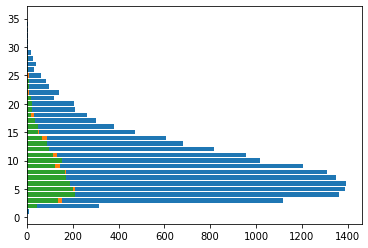

In [15]:
# Plotting the ID histogram to see the distribution
import matplotlib.pyplot as plt

plt.barh(range(1,35+1), histo_plot_data[0,:])
plt.barh(range(1,35+1), histo_plot_data[1,:])
plt.barh(range(1,35+1), histo_plot_data[2,:])

Pad each sample to the same length.

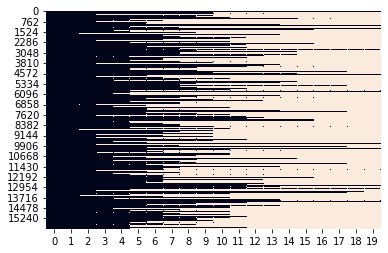

In [16]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

# Honestly don't know what this is doing, I just followed the website's instructions
# Looks like this shows the padding heat map or something similar to that
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Obtain the Embedding Matrix, which is necessary for the machine learning algorithm.

In [17]:
embeddings = np.zeros((len(dic_vocabulary)+1, 25))
counter=0
for word, idx in dic_vocabulary.items():
    # embeddings[idx] = word_embed[word]
    try:
        # Reminder: word_embed is the pre-trained word embedding model...
        embeddings[idx] = word_embed[word]
    except:
        counter += 1
        pass

print(f"Number of words in dictionary that have been assigned a matrix of 0's: {counter}")

# word = "data"
# print("dic[word]:", dic_vocabulary[word], "|idx")
# print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
#       "|vector")

Number of words in dictionary that have been assigned a matrix of 0's: 872


### Neural Network

Referencing source: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [18]:
from keras.models import Sequential
from keras import layers, models, optimizers
import keras

def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name='attention')(x)
    x = layers.multiply([inputs, x])
    return x

# input
x_in = layers.Input(shape=(maxlen,))

# embedding
# trainable=False means that these embedding weights will not change. What if they did though?
x = layers.Embedding(input_dim=embeddings.shape[0],
                     output_dim=embeddings.shape[1],
                     weights=[embeddings],
                     input_length=maxlen, trainable=True)(x_in)

# apply attention
x = attention_layer(x, neurons=maxlen)

# 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=maxlen, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=maxlen, dropout=0.2))(x)

# final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(6, activation='softmax')(x)

classifier_model = models.Model(x_in, y_out)
classifier_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 25)       336975      ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 25, 20)       0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 25, 20)       420         ['permute[0][0]']                
                                                                                              

In [19]:
# The fitting method should be placed in a variable so that results can be easily extracted later...
# For now, I would like to see training happening in real time, so making it verbose I guess.
# Still need to adjust hyper-parameters for better results... if I can get better results.
# batch_size=256 (default given on the website)
history = classifier_model.fit(x=X_train, y=data_train['emotion_enc'], batch_size=32, epochs=20,
                     shuffle=True, verbose=1, validation_data=[X_val, data_val['emotion_enc']])

Epoch 1/20
500/500 [==============================] - 28s 35ms/step - loss: 1.4869 - accuracy: 0.4192 - val_loss: 1.2945 - val_accuracy: 0.5290
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 1.2516 - accuracy: 0.5294 - val_loss: 1.1504 - val_accuracy: 0.5675
Epoch 3/20
500/500 [==============================] - 14s 29ms/step - loss: 1.0957 - accuracy: 0.5745 - val_loss: 1.0338 - val_accuracy: 0.5890
Epoch 4/20
500/500 [==============================] - 14s 29ms/step - loss: 0.9183 - accuracy: 0.6382 - val_loss: 0.8796 - val_accuracy: 0.6640
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.7112 - accuracy: 0.7279 - val_loss: 0.6859 - val_accuracy: 0.7600
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.5376 - accuracy: 0.8036 - val_loss: 0.5716 - val_accuracy: 0.8065
Epoch 7/20
500/500 [==============================] - 14s 29ms/step - loss: 0.4228 - accuracy: 0.8521 - val_loss: 0.5107 - val_accuracy:

Test data on the fitted model using `model.evaluate()`. Also get the probabilities of each sentence via `model.predict()`

In [20]:
# classifier_model.evaluate(X_test, data_test["emotion_enc"], batch_size=1)
y_test_predict = classifier_model.predict(X_test)
y_test_predict_encoded = [np.argmax(item) for item in y_test_predict]
y_test_actual = [item for item in data_test["emotion_enc"]]

In [21]:
import sklearn
accuracy = sklearn.metrics.accuracy_score(y_test_actual, y_test_predict_encoded)
print("Accuracy:",  round(accuracy,3))
print("Detail:")
print(sklearn.metrics.classification_report(y_test_actual, y_test_predict_encoded,
      target_names=emotion_label_list["emotion"]))

Accuracy: 0.896
Detail:
              precision    recall  f1-score   support

       anger       0.87      0.93      0.90       275
        fear       0.93      0.84      0.88       224
         joy       0.90      0.94      0.92       695
        love       0.83      0.69      0.75       159
     sadness       0.93      0.92      0.92       581
    surprise       0.72      0.74      0.73        66

    accuracy                           0.90      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.90      0.90      0.89      2000



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Text major ticklabel objects>)

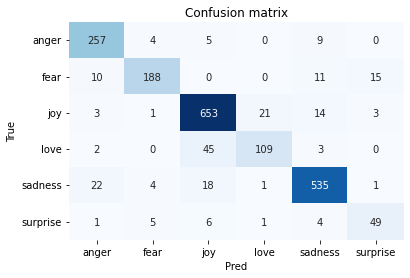

In [22]:
import seaborn as sns
cm = sklearn.metrics.confusion_matrix(y_test_actual, y_test_predict_encoded)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=emotion_label_list["emotion"], 
       yticklabels=emotion_label_list["emotion"], title="Confusion matrix")
plt.yticks(rotation=0)

### [IGNORE] ~Using GloVe (Pre-trained Word Embeddings)~

In [ ]:
# IGNORE this code block for now.
# import numpy as np

# def create_embedding_matrix(model, word_index, embedding_dim):
#     counter=0
#     vocab_size = len(word_index) + 1
#     embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
    
#     for word in word_index:
#         idx = word_index[word]
#         try:
#             tmp_vec = model[word]
#         except:
#             tmp_vec = np.zeros(embedding_dim)
#             counter += 1

#         embedding_matrix[idx] = np.array(tmp_vec, dtype=np.float32)[:embedding_dim]
    
#     # with open(filepath) as f:
#     #     for line in f:
#     #         word, *vector = line.split()
#     #         if word in word_index:
#     #             idx = word_index[word]
#     #             embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
#     print(f"Word Index length: {len(word_index)}. Total number of 0's: {counter}")
#     return embedding_matrix

In [ ]:
# word_index['test']
# word_embed['test']
# t1, *test = model['test']
# print(t1)
# print(test)
# print(*test)

In [ ]:
# IGNORE this code block for now.
# embedding_dim = 25
# embedding_matrix = create_embedding_matrix(word_embed, tokenizer.word_index, embedding_dim)

### **[IGNORE]** Training Neural Network

In [ ]:
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
#     # fit the training dataset on the classifier
#     classifier.fit(feature_vector_train, label)
    
#     # predict the labels on validation dataset
#     predictions = classifier.predict(feature_vector_valid)
    
#     if is_neural_net:
#         predictions = predictions.argmax(axis=-1)
    
#     return metrics.accuracy_score(predictions, data_val['label_enc'])

In [ ]:
# # Test CNN (This doesn't work of course lol...)
# from keras.models import Sequential
# from keras import layers, models, optimizers

# # Add an Input Layer
# input_layer = layers.Input((50, ))

# # Add the word embedding Layer
# embedding_layer = layers.Embedding(vocab_size, 25, weights=[embedding_matrix], trainable=False)(input_layer)
# embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

# # Add the convolutional Layer
# conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

# # Add the pooling Layer
# pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

# # Add the output Layers
# output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
# output_layer1 = layers.Dropout(0.25)(output_layer1)
# output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

# # Compile the model
# model = models.Model(inputs=input_layer, outputs=output_layer2)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# accuracy = train_model(model, X_train, data_train['label_enc'], X_val, is_neural_net=True)
# print("CNN, Word Embeddings", accuracy)

# history = model.fit(X_train, data_train['label_enc'],
#                     epochs=10,
#                     validation_data=(X_test, data_test['label_enc']),
#                     batch_size=10)



# embedding_dim = 50
# model = Sequential()
# model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
# model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# history = model.fit(X_train, data_train['label_enc'],
#                     epochs=10,
#                     validation_data=(X_test, data_test['label_enc']),
#                     batch_size=10)

### **[IGNORE]** Ignore commented code (below) for the rest of this section.

In [ ]:
# Testing n-grams stuff here.
# import nltk
# from nltk.util import ngrams
# from collections import Counter

# corpus = data_train["sentence"]
# for string in corpus:
#     token = nltk.word_tokenize(string)
#     bigrams = ngrams(token,2)
#     trigrams = ngrams(token,3)
# print(Counter(trigrams))

In [ ]:
# Train our own word embedding model based on our own data set.
# corpus = data_train["sentence"]

# Create list of lists of unigrams
# lst_corpus = []
# for string in corpus:
#     lst_words = string.split()
#     lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
#     lst_corpus.append(lst_grams)


# Detect bigrams and trigrams
# bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)
# bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

# trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)
# trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

# nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=25, window=8, min_count=1, sg=1, epochs=30)
# word = "data"
# nlp[word].shape

In [ ]:
# Testing code from StackOverflow
# https://stackoverflow.com/questions/46129335/get-bigrams-and-trigrams-in-word2vec-gensim
# documents = ["the mayor of new york was there", "machine learning can be useful sometimes","new york mayor was present"]

# sentence_stream = [doc.split(" ") for doc in documents]
# print(sentence_stream)

# bigram = gensim.models.phrases.Phrases(sentence_stream, min_count=1, threshold=2, delimiter=b' ')

# bigram_phraser = gensim.models.phrases.Phraser(bigram)


# print(bigram_phraser)

# for sent in sentence_stream:
#     tokens_ = bigram_phraser[sent]

#     print(tokens_)

In [ ]:
# Testing: Gets the index of where the embedded model
# model.vocab["whatever"].index
# Now use the source above, section 2.3 and follow instructions there.
# (And write it in the section below)

# IGNORE THINGS IN THIS SECTION.

**Ignore code blocks below this one please.**

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')

# # Filter out stopwords
# stop_words = set(stopwords.words('english'))

# words = [word for word in words if not word in stop_words]

In [ ]:
# from keras_preprocessing.text import Tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(pd.concat(data_train, axis=0))

In [ ]:
# vocabSize = 15000

Padding will require the text to be already in numbers... so I can't run this yet.

In [ ]:
# from nltk.stem.porter import PorterStemmer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import re

# def text_cleaning(df, column):
#   stemmer = PorterStemmer()
#   corpus = []

#   for text in df[column]:
#     text = re.sub("[^a-zA-Z]", " ", text)
#     text = text.lower()
#     text = text.split()
#     text = [stemmer.stem(word) for word in text if word not in stop_words]
#     text = " ".join(text)
#     corpus.append(text)
  
#   # pad = pad_sequences(sequences=corpus, maxlen=max_len, padding='pre')
#   # return pad
#   return corpus

In [ ]:
# data_train_clean = text_cleaning(data_train, 'sentence')
# data_test_clean = text_cleaning(data_test, 'sentence')
# data_val_clean = text_cleaning(data_val, 'sentence')

## Pre-Processing: Method 1

Source: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [ ]:
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn import decomposition, ensemble

# import pandas, xgboost, numpy, textblob, string
# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers

# train_seq_x = sequence.pad_sequences(token.texts_to_sequences(data_train['sentence']), maxlen=300)
# test_seq_x = sequence.pad_sequences(token.texts_to_sequences(data_test['sentence']), maxlen=300)
# valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(data_val['sentence']), maxlen=300)

In [ ]:
# Create list of strings into a single long string for processing
# title_list = [title for title in data_train['sentence']]

# We definitely are not doing this.
# Collapse the list of strings into a single long string for processing
# big_title_string = ' '.join(title_list)

In [ ]:
# from nltk.tokenize import word_tokenize
# Tokenize the string into words
# tokens = word_tokenize(big_title_string)

# Filter out stopwords
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))

# words = [word for word in words if not word in stop_words]

## Pre-Processing: Method 2

Sources:

* https://github.com/adsieg/Multi_Text_Classification/blob/master/%5BIntroduction%5D%20-%20Big%20tutorial%20-%20Text%20Classification.ipynb
* https://www.tensorflow.org/text/guide/word_embeddings
* Only BOW and TF-IDF: https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches/

In [ ]:
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn import decomposition, ensemble

# import pandas, xgboost, numpy, textblob, string
# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers

In [ ]:
# data_train['length'] = [len(x) for x in token]
# data_train.head()
# max_len = data_train['length'].max()
# print(max_len)

## Word Vectorization

We can use the `gensim` library to train our own word2vec model on a custom corpus either with CBOW or Skip Gram.

word2vec cannot create a vector from a word that is not in its vocabulary. So we need to specify "if word in model.vocab" when creating the full list of word vectors (source: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751)

In [ ]:
# Relevant Libraries for Word Vectorization
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn import decomposition, ensemble
# from sklearn.preprocessing import LabelEncoder

# !pip install nltk
# !pip install gensim
# import gensim
# from nltk.tokenize import sent_tokenize, word_tokenize
# from gensim.models import Word2Vec